In [1]:
import numpy as np 
import pandas as pd
import itertools
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from lightgbm import LGBMClassifier

CurrYear = 2019

In [2]:
def LogLoss(predictions, realizations):
    predictions_use = predictions.clip(0)
    realizations_use = realizations.clip(0)
    LogLoss = -np.mean( (realizations_use * np.log(predictions_use)) + (1 - realizations_use) * np.log(1 - predictions_use) )
    return LogLoss

In [3]:
KenPomFinal2 = pd.read_csv("../input/kp-hs-10-100/KenPomFinal.csv")
teamsAll = pd.read_csv("../input/teamsall/TeamsAll.csv")
regseasonDetail = pd.read_csv('../input/mens-machine-learning-competition-2019/Stage2DataFiles/RegularSeasonDetailedResults.csv')

In [4]:
KenPomFinal2 = KenPomFinal2[['Team','Year','AdjD','AdjO','Conf','Luck','Pyth','Team_Id']]

In [5]:
kp_df=[]
years_list = [2019,2018,2017,2016,2015,2014,2013,2012,2011,2010,2009,2008,2007,2006,2005,2004,2003,2002]
for year in years_list:
    temp_kp_df = pd.read_csv('../input/' + 'ken-pom2019/KP' + str(year) + "_final.csv")
    temp_kp_df['Season'] = year
    year_last = year   
    if year==2019:
        kp_df = temp_kp_df
    else:
        kp_df = kp_df.append(temp_kp_df)

KenPomFinal = kp_df
KenPomFinal.rename(columns={'team':'Team','conf':'Conf','adjem':'Pyth','adjo':'AdjO','adjd':'AdjD','luck':'Luck','Season':'Year'},inplace=True)
KenPomFinal = KenPomFinal.merge(KenPomFinal2,left_on=['Year','Team'], right_on=["Year","Team"],how='left')
KenPomFinal = KenPomFinal[['Team','Year','AdjD_x','AdjO_x','Conf_x','Luck_x','Pyth_x','Team_Id']]
KenPomFinal.rename(columns={'AdjD_x':'AdjD','AdjO_x':'AdjO','Conf_x':'Conf','Luck_x':'Luck','Pyth_x':'Pyth'},inplace=True)

In [6]:
regseasonWin = regseasonDetail.copy()
regseasonWin['Win']=1

regseasonWin.columns = [
    "Year","daynum","Team","Score","OppTeam","OppScore","Location","numOT","fgm","fga","fgm3","fga3","ftm","fta","or","dr","ast","to","stl",
    "blk","pf","Oppfgm","Oppfga","Oppfgm3","Oppfga3","Oppftm","Oppfta","Oppor","Oppdr","Oppast","Oppto","Oppstl","Oppblk","Opppf", "Win"]

regseasonLoss = regseasonDetail.copy()
regseasonLoss['Win']=0

regseasonLoss.columns = ["Year","daynum","OppTeam","OppScore","Team","Score","Location","numOT","Oppfgm","Oppfga","Oppfgm3","Oppfga3","Oppftm","Oppfta",
"Oppor","Oppdr","Oppast","Oppto","Oppstl","Oppblk","Opppf","fgm","fga","fgm3","fga3","ftm","fta","or","dr","ast","to","stl","blk","pf","Win"]

In [7]:
regseasonLoss.loc[regseasonLoss.Location == 'H', 'Location'] = 'B'
regseasonLoss.loc[regseasonLoss.Location == 'A', 'Location'] = 'H'
regseasonLoss.loc[regseasonLoss.Location == 'B', 'Location'] = 'A'

RegSeasonTotal = pd.concat([regseasonWin,regseasonLoss],sort=False)

In [8]:
RegSeasonTotal['FGPerct'] = RegSeasonTotal.fgm/RegSeasonTotal.fga
RegSeasonTotal['FG3Perct'] = RegSeasonTotal.fgm3/RegSeasonTotal.fga3
RegSeasonTotal['FTPerct'] = (RegSeasonTotal.ftm/RegSeasonTotal.fta).fillna(0)
RegSeasonTotal['O_Eff'] = 100*RegSeasonTotal.Score /(0.5*((RegSeasonTotal.fga+0.4*RegSeasonTotal.fta-1.07*\
                        (RegSeasonTotal['or']/(RegSeasonTotal['or']+RegSeasonTotal.Oppdr))*(RegSeasonTotal.fga-RegSeasonTotal.fgm)+\
                        RegSeasonTotal.to)+(RegSeasonTotal.Oppfga+0.4*RegSeasonTotal.Oppfta-1.07*(RegSeasonTotal.Oppor/\
                        (RegSeasonTotal.Oppor+RegSeasonTotal.dr))*(RegSeasonTotal.Oppfga-RegSeasonTotal.Oppfgm)+RegSeasonTotal.Oppto)))
RegSeasonTotal['D_Eff'] = 100*RegSeasonTotal.OppScore/(RegSeasonTotal.Oppfga-RegSeasonTotal.Oppor+RegSeasonTotal.Oppto+0.4*RegSeasonTotal.Oppfta)

In [9]:
var_gb = RegSeasonTotal.groupby(['Team','Year'])[['FGPerct','FG3Perct','FTPerct','to']].var()
mean_gb = RegSeasonTotal.groupby(['Team','Year'])[['fgm3','fga3','fgm','fga','ftm','fta','or','dr','ast','to','stl','blk',
                                                                                               'pf','O_Eff','D_Eff']].mean()
var_gb.columns = ['FGPerctVar','FG3PerctVar','FTPerctVar','toVar']
mean_gb.columns = ['fgm3agg','fga3agg','fgmagg','fgaagg','ftmagg','ftaagg','oragg','dragg','astagg','toagg','stlagg',
                                                                                           'blkagg','pfagg','OffRtg','DffRtg']
sumRegSeason = pd.concat([mean_gb,var_gb],axis=1).reset_index()

sumRegSeason['ast2to'] = sumRegSeason.astagg/sumRegSeason.toagg

In [10]:
last30regseas  = RegSeasonTotal.loc[RegSeasonTotal.daynum > 100]

var_gb30 = last30regseas.groupby(['Team','Year'])[['FGPerct','FG3Perct','FTPerct','to']].var()
mean_gb30 = last30regseas.groupby(['Team','Year'])[['fgm3','fga3','fgm','fga','ftm','fta','or','dr','ast','to','stl','blk',
                                                                                                'pf','O_Eff','D_Eff']].mean()
var_gb30.columns = ['FGPerctVarl30','FG3PerctVarl30','FTPerctVarl30','toVarl30']
mean_gb30.columns = ['fgm3aggl30','fga3aggl30','fgmaggl30','fgaaggl30','ftmaggl30','ftaaggl30','oraggl30','draggl30','astaggl30',
                                                             'toaggl30','stlaggl30','blkaggl30','pfaggl30','OffRtgl30','DffRtgl30']
last30regseas = pd.concat([mean_gb30,var_gb30],axis=1).reset_index()
last30regseas['ast2tol30'] = last30regseas.astaggl30/last30regseas.toaggl30

In [11]:
MasseyOrdinals = pd.read_csv("../input/masseyordinals-thru-2019-day-128/MasseyOrdinals_thru_2019_day_128.csv")

MasseyOrdinalTable = pd.melt(MasseyOrdinals, id_vars=['Season','RankingDayNum','SystemName','TeamID'], value_vars=['OrdinalRank'],
                             var_name='variable',value_name='value')
MasseyOrdinalTable = (MasseyOrdinalTable.pivot_table(index=['Season', 'SystemName','TeamID'], columns=['RankingDayNum'],values='value').\
                                                                                                                            reset_index())
MasseyOrdinalTable.columns= ['Season','SystemName','TeamID']+[str(i)+'_OrdinalRank'for i in list(MasseyOrdinalTable.iloc[:,3:].columns)]

MasseyOrdinalTable['MinRank'] = MasseyOrdinalTable.iloc[:,3:93].min(axis=1)
MasseyOrdinalTable['MaxRank'] = MasseyOrdinalTable.iloc[:,3:93].max(axis=1)
MasseyOrdinalTable['VarRank'] = MasseyOrdinalTable.iloc[:,3:93].var(axis=1)
MasseyOrdinalTable.rename(columns={'133_OrdinalRank': "FinalRanking" }, inplace = True)

MasseyOrdinalTable['FinalRanking'] = MasseyOrdinalTable['FinalRanking'].fillna(MasseyOrdinalTable['128_OrdinalRank'])
MasseyOrdinalTable = MasseyOrdinalTable[['Season', 'SystemName', 'TeamID','FinalRanking', 'MinRank','MaxRank', 'VarRank']]
MasseyOrdinalTable = pd.melt(MasseyOrdinalTable, id_vars=["Season","SystemName","TeamID"], value_vars=["FinalRanking","MinRank","MaxRank","VarRank"])

MasseyOrdinalTable = (MasseyOrdinalTable.pivot_table(index=['Season', 'TeamID'], columns=['SystemName','variable'],values='value').reset_index())
MasseyOrdinalTable.columns = MasseyOrdinalTable.columns.map('_'.join)
MasseyOrdinalTable.rename(columns={'Season_':'Season','TeamID_':'TeamID'},inplace=True)

FinalRankings = MasseyOrdinalTable[['Season', 'TeamID', 'MAS_FinalRanking','MAS_MinRank','MAS_MaxRank','MAS_VarRank','COL_FinalRanking','COL_MinRank',
                    'COL_MaxRank','COL_VarRank','RPI_FinalRanking','RPI_MinRank','RPI_MaxRank','RPI_VarRank']]

In [12]:
TourneyCompact = pd.read_csv('../input/mens-machine-learning-competition-2019/Stage2DataFiles/NCAATourneyCompactResults.csv')
TourneySeeds = pd.read_csv('../input/mens-machine-learning-competition-2019/Stage2DataFiles/NCAATourneySeeds.csv')

TourneyWin  = TourneyCompact.copy()
TourneyWin['Win'] = 1
TourneyWin.columns = ["Year","Daynum","Team","Score","OppTeam","OppScore","Location","Numot","Win"]

TourneyLose = TourneyCompact.copy()
TourneyLose['Win'] = 0
TourneyLose.columns = ["Year","Daynum","OppTeam","OppScore","Team","Score","Location","Numot","Win"]

TourneyTotal = pd.concat([TourneyWin,TourneyLose],sort=False)
TourneySeeds['SeedNum'] = TourneySeeds.Seed.str.extract('(\d+)').astype('int32')

In [13]:
TourneyTotal = TourneyTotal.merge(TourneySeeds.rename(columns={'Season': 'Year','TeamID': 'Team'}),
   left_on=['Year','Team'], right_on=["Year","Team"])
TourneyTotal = TourneyTotal.merge(TourneySeeds.rename(columns={'Season': 'Year','TeamID': 'OppTeam'}),
                                  left_on=['Year','OppTeam'], right_on=["Year","OppTeam"],suffixes=[".x", ".y"])

TourneyTotal['SeedDiff'] = TourneyTotal['SeedNum.x']-TourneyTotal['SeedNum.y']
Tourney03to11 = TourneyTotal.loc[TourneyTotal.Year>2002]

#add Ken Pom
KenPomFinal_1 = KenPomFinal.iloc[:,1:23]
Tourney03to11 = Tourney03to11.merge(KenPomFinal_1.rename(columns={'Team_Id': 'Team'}),
                                  left_on=['Year','Team'], right_on=["Year","Team"],how='left')
Tourney03to11 = Tourney03to11.merge(KenPomFinal_1.rename(columns={'Team_Id': 'OppTeam'}),
                                   left_on=['Year','OppTeam'], right_on=["Year","OppTeam"],suffixes=[".x", ".y"],how='left')

#add sumRegSeason
Tourney03to11 = Tourney03to11.merge(sumRegSeason,left_on=['Year','Team'], right_on=["Year","Team"],how='left')
Tourney03to11 = Tourney03to11.merge(sumRegSeason.rename(columns={'Team': 'OppTeam'}),left_on=['Year','OppTeam'],
                                    right_on=["Year","OppTeam"],suffixes=[".x", ".y"],how='left')

#add last30regseas
Tourney03to11 = Tourney03to11.merge(last30regseas,left_on=['Year','Team'], right_on=["Year","Team"],how='left')
Tourney03to11 = Tourney03to11.merge(last30regseas.rename(columns={'Team': 'OppTeam'}),left_on=['Year','OppTeam'],
                                    right_on=["Year","OppTeam"],suffixes=[".x", ".y"],how='left')

#add FinalRankings
Tourney03to11 = Tourney03to11.merge(FinalRankings.rename(columns={'Season': 'Year','TeamID': 'Team'}),
                                    left_on=['Year','Team'], right_on=["Year","Team"],how='left')
Tourney03to11 = Tourney03to11.merge(FinalRankings.rename(columns={'Season': 'Year','TeamID': 'OppTeam'}),
                                    left_on=['Year','OppTeam'],right_on=["Year","OppTeam"],suffixes=[".x", ".y"],how='left')

In [14]:
Tourney03to11['AdjDDiff'] = Tourney03to11['AdjD.x']-Tourney03to11['AdjD.y']
Tourney03to11['AdjDDiff'] = Tourney03to11['AdjD.x']-Tourney03to11['AdjD.y']
Tourney03to11['AdjODiff'] = Tourney03to11['AdjO.x']-Tourney03to11['AdjO.y']

In [15]:
Tourney03to11 = Tourney03to11.loc[:,~Tourney03to11.columns.duplicated()]

In [16]:
Tourney03to11['ast2tol30Diff'] = Tourney03to11['ast2tol30.x'] - Tourney03to11['ast2tol30.y']
Tourney03to11['astaggDiff'] = Tourney03to11['astagg.x'] - Tourney03to11['astagg.y']
Tourney03to11['astaggl30Diff'] = Tourney03to11['astaggl30.x'] - Tourney03to11['astaggl30.y']
Tourney03to11['blkaggDiff'] = Tourney03to11['blkagg.x'] - Tourney03to11['blkagg.y']
Tourney03to11['blkaggl30Diff'] = Tourney03to11['blkaggl30.x'] - Tourney03to11['blkaggl30.y']
Tourney03to11['draggDiff'] = Tourney03to11['dragg.x'] - Tourney03to11['dragg.y']
Tourney03to11['draggl30Diff'] = Tourney03to11['draggl30.x'] - Tourney03to11['draggl30.y']
Tourney03to11['FG3PerctVarDiff'] = Tourney03to11['FG3PerctVar.x'] - Tourney03to11['FG3PerctVar.y']
Tourney03to11['FG3PerctVarl30Diff'] = Tourney03to11['FG3PerctVarl30.x'] - Tourney03to11['FG3PerctVarl30.y']
Tourney03to11['fga3aggDiff'] = Tourney03to11['fga3agg.x'] - Tourney03to11['fga3agg.y']
Tourney03to11['fga3aggl30Diff'] = Tourney03to11['fga3aggl30.x'] - Tourney03to11['fga3aggl30.y']
Tourney03to11['fgaaggDiff'] = Tourney03to11['fgaagg.x'] - Tourney03to11['fgaagg.y']
Tourney03to11['fgaaggl30Diff'] = Tourney03to11['fgaaggl30.x'] - Tourney03to11['fgaaggl30.y']
Tourney03to11['fgm3aggDiff'] = Tourney03to11['fgm3agg.x'] - Tourney03to11['fgm3agg.y']
Tourney03to11['fgm3aggl30Diff'] = Tourney03to11['fgm3aggl30.x'] - Tourney03to11['fgm3aggl30.y']
Tourney03to11['fgmaggDiff'] = Tourney03to11['fgmagg.x'] - Tourney03to11['fgmagg.y']
Tourney03to11['fgmaggl30Diff'] = Tourney03to11['fgmaggl30.x'] - Tourney03to11['fgmaggl30.y']
Tourney03to11['FGPerctVarDiff'] = Tourney03to11['FGPerctVar.x'] - Tourney03to11['FGPerctVar.y']
Tourney03to11['FGPerctVarl30Diff'] = Tourney03to11['FGPerctVarl30.x'] - Tourney03to11['FGPerctVarl30.y']
Tourney03to11['ftaaggDiff'] = Tourney03to11['ftaagg.x'] - Tourney03to11['ftaagg.y']
Tourney03to11['ftaaggl30Diff'] = Tourney03to11['ftaaggl30.x'] - Tourney03to11['ftaaggl30.y']
Tourney03to11['ftmaggDiff'] = Tourney03to11['ftmagg.x'] - Tourney03to11['ftmagg.y']
Tourney03to11['ftmaggl30Diff'] = Tourney03to11['ftmaggl30.x'] - Tourney03to11['ftmaggl30.y']
Tourney03to11['FTPerctVarDiff'] = Tourney03to11['FTPerctVar.x'] - Tourney03to11['FTPerctVar.y']
Tourney03to11['FTPerctVarl30Diff'] = Tourney03to11['FTPerctVarl30.x'] - Tourney03to11['FTPerctVarl30.y']
Tourney03to11['LuckDiff'] = Tourney03to11['Luck.x']-Tourney03to11['Luck.y']
Tourney03to11['oraggDiff'] = Tourney03to11['oragg.x'] - Tourney03to11['oragg.y']
Tourney03to11['oraggl30Diff'] = Tourney03to11['oraggl30.x'] - Tourney03to11['oraggl30.y']
Tourney03to11['pfaggDiff'] = Tourney03to11['pfagg.x'] - Tourney03to11['pfagg.y']
Tourney03to11['pfaggl30Diff'] = Tourney03to11['pfaggl30.x'] - Tourney03to11['pfaggl30.y']
Tourney03to11['PythDiff'] = Tourney03to11['Pyth.x']-Tourney03to11['Pyth.y']
Tourney03to11['SeedNumDiff'] = Tourney03to11['SeedNum.x'] - Tourney03to11['SeedNum.y']
Tourney03to11['stlaggDiff'] = Tourney03to11['stlagg.x'] - Tourney03to11['stlagg.y']
Tourney03to11['stlaggl30Diff'] = Tourney03to11['stlaggl30.x'] - Tourney03to11['stlaggl30.y']
Tourney03to11['toaggDiff'] = Tourney03to11['toagg.x'] - Tourney03to11['toagg.y']
Tourney03to11['toaggl30Diff'] = Tourney03to11['toaggl30.x'] - Tourney03to11['toaggl30.y']
Tourney03to11['toVarl30Diff'] = Tourney03to11['toVarl30.x'] - Tourney03to11['toVarl30.y']
Tourney03to11['PerctOfrom3pt.x'] = (3*Tourney03to11['fgm3agg.x'])/(Tourney03to11['fgm3agg.x']*3+Tourney03to11['fgmagg.x']*2+Tourney03to11['ftmagg.x'])
Tourney03to11['PerctOfrom3pt.y'] = (3*Tourney03to11['fgm3agg.y'])/(Tourney03to11['fgm3agg.y']*3+Tourney03to11['fgmagg.y']*2+Tourney03to11['ftmagg.y'])
Tourney03to11['PerctOfrom3ptDiff'] = Tourney03to11['PerctOfrom3pt.x']-Tourney03to11['PerctOfrom3pt.y']
Tourney03to11['PerctOfromFT.x'] = Tourney03to11['ftmagg.x']/(Tourney03to11['fgm3agg.x']*3+Tourney03to11['fgmagg.x']*2+Tourney03to11['ftmagg.x'])
Tourney03to11['PerctOfromFT.y'] = Tourney03to11['ftmagg.y']/(Tourney03to11['fgm3agg.y']*3+Tourney03to11['fgmagg.y']*2+Tourney03to11['ftmagg.y'])
Tourney03to11['PerctOfromFTDiff'] = Tourney03to11['PerctOfrom3pt.x']-Tourney03to11['PerctOfrom3pt.y']
Tourney03to11['AggresPrct.x'] = (Tourney03to11['ftmagg.x']/Tourney03to11['fgmagg.x'])/(Tourney03to11['fgm3agg.x']/Tourney03to11['fgmagg.x'])
Tourney03to11['AggresPrct.y'] = (Tourney03to11['ftmagg.y']/Tourney03to11['fgmagg.y'])/(Tourney03to11['fgm3agg.y']/Tourney03to11['fgmagg.y'])
Tourney03to11['AggresPrctDiff'] = Tourney03to11['AggresPrct.x']-Tourney03to11['AggresPrct.y']
Tourney03to11['After1stWkd'] = np.where(Tourney03to11['Daynum']>140, 1, 0)
Tourney03to11['RemoveDups'] = np.where(Tourney03to11['Team']>Tourney03to11.OppTeam, 0, 1)
Tourney03to11['Eff_L30_Diff'] =  (Tourney03to11['OffRtgl30.x']-Tourney03to11['DffRtgl30.x'])-(Tourney03to11['OffRtgl30.y']-Tourney03to11['DffRtgl30.y'])
Tourney03to11['OffMomentum.x'] =  Tourney03to11['OffRtgl30.x']/Tourney03to11['OffRtg.x']
Tourney03to11['DefMomentum.x'] =  Tourney03to11['DffRtgl30.x']/Tourney03to11['DffRtg.x']
Tourney03to11['OffMomentum.y'] =  Tourney03to11['OffRtgl30.y']/Tourney03to11['OffRtg.y']
Tourney03to11['DefMomentum.y'] =  Tourney03to11['DffRtgl30.y']/Tourney03to11['DffRtg.y']
Tourney03to11['OffMomentumDiff'] =  Tourney03to11['OffMomentum.x']-Tourney03to11['OffMomentum.y']
Tourney03to11['DefMomentumDiff'] =  Tourney03to11['DefMomentum.x']-Tourney03to11['DefMomentum.y']
Tourney03to11['MAS_Final_Diff'] =  Tourney03to11['MAS_FinalRanking.x']-Tourney03to11['MAS_FinalRanking.y']
Tourney03to11['MAS_Min_Diff'] =  Tourney03to11['MAS_MinRank.x']-Tourney03to11['MAS_MinRank.y']
Tourney03to11['MAS_Max_Diff'] =  Tourney03to11['MAS_MaxRank.x']-Tourney03to11['MAS_MaxRank.y']
Tourney03to11['MAS_Var_Diff'] =  Tourney03to11['MAS_VarRank.x']-Tourney03to11['MAS_VarRank.y']
Tourney03to11['COL_Final_Diff'] =  Tourney03to11['COL_FinalRanking.x']-Tourney03to11['COL_FinalRanking.y']
Tourney03to11['COL_Min_Diff'] =  Tourney03to11['COL_MinRank.x']-Tourney03to11['COL_MinRank.y']
Tourney03to11['COL_Max_Diff'] =  Tourney03to11['COL_MaxRank.x']-Tourney03to11['COL_MaxRank.y']
Tourney03to11['COL_Var_Diff'] =  Tourney03to11['COL_VarRank.x']-Tourney03to11['COL_VarRank.y']
Tourney03to11['RPI_Final_Diff'] =  Tourney03to11['RPI_FinalRanking.x']-Tourney03to11['RPI_FinalRanking.y']
Tourney03to11['RPI_Min_Diff'] =  Tourney03to11['RPI_MinRank.x']-Tourney03to11['RPI_MinRank.y']
Tourney03to11['RPI_Max_Diff'] =  Tourney03to11['RPI_MaxRank.x']-Tourney03to11['RPI_MaxRank.y']
Tourney03to11['RPI_Var_Diff'] =  Tourney03to11['RPI_VarRank.x']-Tourney03to11['RPI_VarRank.y']

Tourney03to11 = Tourney03to11.fillna(0)
TourneyDataTotal = Tourney03to11.loc[Tourney03to11.RemoveDups==1]

In [17]:
TeamNames = teamsAll[["Team_Id","Team_Name"]]
TeamNames = TeamNames.drop_duplicates()
TourneyDataTotal = TourneyDataTotal.merge(TeamNames,left_on=['Team'], right_on=["Team_Id"],how='left')
TeamNames.rename(columns={'Team_Name':'Opp_Team_Name'},inplace=True)
TourneyDataTotal = TourneyDataTotal.merge(TeamNames,left_on=['OppTeam'], right_on=["Team_Id"],how='left')
TeamNames.rename(columns={'Opp_Team_Name':'Team_Name'},inplace=True)

In [18]:
ind_var_selected = ['SeedDiff','LuckDiff','PythDiff','MAS_Final_Diff','MAS_Max_Diff','COL_Final_Diff']

In [19]:
# Classification
valid_seasons = [2015,2016,2017,2018]
error = []
for vseason in valid_seasons:
    temp_df = TourneyDataTotal[TourneyDataTotal['Year'] == vseason]
    X_valid = temp_df[ind_var_selected].reset_index(drop=True)
    y_valid = temp_df['Win'].reset_index(drop=True)
    

    temp_df1 = TourneyDataTotal[TourneyDataTotal['Year'] < vseason]
    combined_temp_df = temp_df1.sample(frac=1, random_state=3)
    
    X_train = combined_temp_df[ind_var_selected].reset_index(drop=True)
    y_train = combined_temp_df['Win'].reset_index(drop=True)
    
    scaler = StandardScaler()
    scaler.fit(X_train)
    scaled_X_train = pd.DataFrame(scaler.transform(X_train), index=X_train.index, columns=X_train.columns)
    scaled_X_valid = pd.DataFrame(scaler.transform(X_valid), index=X_valid.index, columns=X_valid.columns)
    
    roll_score=[]
    df_step = pd.DataFrame()
    for step in range(5):
        #roll columns
        new_top_cols = np.array(ind_var_selected)
        ind_var_selected = list(np.roll(new_top_cols,step))
        
        nn = LogisticRegression(max_iter=250)
        nn.fit(scaled_X_train[ind_var_selected],y_train)
        nn_pred_no_line = pd.DataFrame(nn.predict_proba(scaled_X_valid[ind_var_selected]))[1]
        df_step[step]=nn_pred_no_line
        print('valid df season',vseason,'=',LogLoss(df_step.mean(axis=1), y_valid))
        print('valid season',vseason,'=',LogLoss(nn_pred_no_line, y_valid))
        roll_score.append(LogLoss(nn_pred_no_line, y_valid))
    print('Final df valid season',vseason,'=',LogLoss(df_step.mean(axis=1), y_valid))
    error.append(LogLoss(df_step.mean(axis=1), y_valid))
print('Final df log loss =',sum(error)/len(error))

valid df season 2015 = 0.3718595382562789
valid season 2015 = 0.3718595382562789
valid df season 2015 = 0.37185953825627893
valid season 2015 = 0.37185953825627904
valid df season 2015 = 0.37185953825628076
valid season 2015 = 0.37185953825628454
valid df season 2015 = 0.3718595382562803
valid season 2015 = 0.3718595382562789
valid df season 2015 = 0.3718595382562824
valid season 2015 = 0.3718595382562905
Final df valid season 2015 = 0.3718595382562824
valid df season 2016 = 0.4013356863443721
valid season 2016 = 0.4013356863443721
valid df season 2016 = 0.40133568634437217
valid season 2016 = 0.40133568634437217
valid df season 2016 = 0.40133568634437217
valid season 2016 = 0.4013356863443722
valid df season 2016 = 0.4013356863443721
valid season 2016 = 0.4013356863443721
valid df season 2016 = 0.4013356863443721
valid season 2016 = 0.40133568634437217
Final df valid season 2016 = 0.4013356863443721
valid df season 2017 = 0.3603270394898758
valid season 2017 = 0.3603270394898758
valid

In [20]:
SubmissionDataSet = TourneySeeds.loc[TourneySeeds.Season == CurrYear]
cat = {'Team': list(SubmissionDataSet.TeamID.values),'OppTeam': list(SubmissionDataSet.TeamID.values)}

order = cat.keys()
Webexpand_NCAA_Tournament = pd.DataFrame(itertools.product(*[cat[k] for k in order]), columns=order)
SubmissionDataSet = Webexpand_NCAA_Tournament.loc[Webexpand_NCAA_Tournament.Team < Webexpand_NCAA_Tournament.OppTeam]
SubmissionDataSet['Year'] = CurrYear
SubmissionDataSet['Id'] = SubmissionDataSet.Year.astype(str)+"_"+SubmissionDataSet.Team.astype(str)+"_"+SubmissionDataSet.OppTeam.astype(str)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [21]:
SubmissionDataSet = SubmissionDataSet.merge(TourneySeeds.rename(columns={'Season': 'Year','TeamID': 'Team'}),
   left_on=['Year','Team'], right_on=["Year","Team"])
SubmissionDataSet = SubmissionDataSet.merge(TourneySeeds.rename(columns={'Season': 'Year','TeamID': 'OppTeam'}),
                                  left_on=['Year','OppTeam'], right_on=["Year","OppTeam"],suffixes=[".x", ".y"])

#add Ken Pom
SubmissionDataSet = SubmissionDataSet.merge(KenPomFinal_1.rename(columns={'Team_Id': 'Team'}),
                                  left_on=['Year','Team'], right_on=["Year","Team"],how='left')
SubmissionDataSet = SubmissionDataSet.merge(KenPomFinal_1.rename(columns={'Team_Id': 'OppTeam'}),
                                   left_on=['Year','OppTeam'], right_on=["Year","OppTeam"],suffixes=[".x", ".y"],how='left')

#add sumRegSeason
SubmissionDataSet = SubmissionDataSet.merge(sumRegSeason,left_on=['Year','Team'], right_on=["Year","Team"],how='left')
SubmissionDataSet = SubmissionDataSet.merge(sumRegSeason.rename(columns={'Team': 'OppTeam'}),left_on=['Year','OppTeam'],
                                    right_on=["Year","OppTeam"],suffixes=[".x", ".y"],how='left')

#add last30regseas
SubmissionDataSet = SubmissionDataSet.merge(last30regseas,left_on=['Year','Team'], right_on=["Year","Team"],how='left')
SubmissionDataSet = SubmissionDataSet.merge(last30regseas.rename(columns={'Team': 'OppTeam'}),left_on=['Year','OppTeam'],
                                    right_on=["Year","OppTeam"],suffixes=[".x", ".y"],how='left')

# #add FinalRankings
SubmissionDataSet = SubmissionDataSet.merge(FinalRankings.rename(columns={'Season': 'Year','TeamID': 'Team'}),
                                    left_on=['Year','Team'], right_on=["Year","Team"],how='left')
SubmissionDataSet = SubmissionDataSet.merge(FinalRankings.rename(columns={'Season': 'Year','TeamID': 'OppTeam'}),
                                    left_on=['Year','OppTeam'],right_on=["Year","OppTeam"],suffixes=[".x", ".y"],how='left')

In [22]:
SubmissionDataSet['SeedDiff'] = SubmissionDataSet['SeedNum.x']-SubmissionDataSet['SeedNum.y']
SubmissionDataSet['AdjDDiff'] = SubmissionDataSet['AdjD.x']-SubmissionDataSet['AdjD.y']
SubmissionDataSet['AdjODiff'] = SubmissionDataSet['AdjO.x']-SubmissionDataSet['AdjO.y']
SubmissionDataSet['ast2tol30Diff']  = SubmissionDataSet['ast2tol30.x']-SubmissionDataSet['ast2tol30.y']
SubmissionDataSet['astaggDiff']  = SubmissionDataSet['astagg.x']-SubmissionDataSet['astagg.y']
SubmissionDataSet['astaggl30Diff']  = SubmissionDataSet['astaggl30.x']-SubmissionDataSet['astaggl30.y']
SubmissionDataSet['blkaggDiff']  = SubmissionDataSet['blkagg.x']-SubmissionDataSet['blkagg.y']
SubmissionDataSet['blkaggl30Diff']  = SubmissionDataSet['blkaggl30.x']-SubmissionDataSet['blkaggl30.y']
SubmissionDataSet['draggDiff']  = SubmissionDataSet['dragg.x']-SubmissionDataSet['dragg.y']
SubmissionDataSet['draggl30Diff']  = SubmissionDataSet['draggl30.x']-SubmissionDataSet['draggl30.y']
SubmissionDataSet['FG3PerctVarDiff']  = SubmissionDataSet['FG3PerctVar.x']-SubmissionDataSet['FG3PerctVar.y']
SubmissionDataSet['FG3PerctVarl30Diff']  = SubmissionDataSet['FG3PerctVarl30.x']-SubmissionDataSet['FG3PerctVarl30.y']
SubmissionDataSet['fga3aggDiff']  = SubmissionDataSet['fga3agg.x']-SubmissionDataSet['fga3agg.y']
SubmissionDataSet['fga3aggl30Diff']  = SubmissionDataSet['fga3aggl30.x']-SubmissionDataSet['fga3aggl30.y']
SubmissionDataSet['fgaaggDiff']  = SubmissionDataSet['fgaagg.x']-SubmissionDataSet['fgaagg.y']
SubmissionDataSet['fgaaggl30Diff']  = SubmissionDataSet['fgaaggl30.x']-SubmissionDataSet['fgaaggl30.y']
SubmissionDataSet['fgm3aggDiff']  = SubmissionDataSet['fgm3agg.x']-SubmissionDataSet['fgm3agg.y']
SubmissionDataSet['fgm3aggl30Diff']  = SubmissionDataSet['fgm3aggl30.x']-SubmissionDataSet['fgm3aggl30.y']
SubmissionDataSet['fgmaggDiff']  = SubmissionDataSet['fgmagg.x']-SubmissionDataSet['fgmagg.y']
SubmissionDataSet['fgmaggl30Diff']  = SubmissionDataSet['fgmaggl30.x']-SubmissionDataSet['fgmaggl30.y']
SubmissionDataSet['FGPerctVarDiff']  = SubmissionDataSet['FGPerctVar.x']-SubmissionDataSet['FGPerctVar.y']
SubmissionDataSet['FGPerctVarl30Diff']  = SubmissionDataSet['FGPerctVarl30.x']-SubmissionDataSet['FGPerctVarl30.y']
SubmissionDataSet['ftaaggDiff']  = SubmissionDataSet['ftaagg.x']-SubmissionDataSet['ftaagg.y']
SubmissionDataSet['ftaaggl30Diff']  = SubmissionDataSet['ftaaggl30.x']-SubmissionDataSet['ftaaggl30.y']
SubmissionDataSet['ftmaggDiff']  = SubmissionDataSet['ftmagg.x']-SubmissionDataSet['ftmagg.y']
SubmissionDataSet['ftmaggl30Diff']  = SubmissionDataSet['ftmaggl30.x']-SubmissionDataSet['ftmaggl30.y']
SubmissionDataSet['FTPerctVarDiff']  = SubmissionDataSet['FTPerctVar.x']-SubmissionDataSet['FTPerctVar.y']
SubmissionDataSet['FTPerctVarl30Diff']  = SubmissionDataSet['FTPerctVarl30.x']-SubmissionDataSet['FTPerctVarl30.y']
SubmissionDataSet['LuckDiff']  = SubmissionDataSet['Luck.x']-SubmissionDataSet['Luck.y']
SubmissionDataSet['oraggDiff']  = SubmissionDataSet['oragg.x']-SubmissionDataSet['oragg.y']
SubmissionDataSet['oraggl30Diff']  = SubmissionDataSet['oraggl30.x']-SubmissionDataSet['oraggl30.y']
SubmissionDataSet['pfaggDiff']  = SubmissionDataSet['pfagg.x']-SubmissionDataSet['pfagg.y']
SubmissionDataSet['pfaggl30Diff']  = SubmissionDataSet['pfaggl30.x']-SubmissionDataSet['pfaggl30.y']
SubmissionDataSet['PythDiff']  = SubmissionDataSet['Pyth.x']-SubmissionDataSet['Pyth.y']
SubmissionDataSet['SeedNumDiff']  = SubmissionDataSet['SeedNum.x']-SubmissionDataSet['SeedNum.y']
SubmissionDataSet['stlaggDiff']  = SubmissionDataSet['stlagg.x']-SubmissionDataSet['stlagg.y']
SubmissionDataSet['stlaggl30Diff']  = SubmissionDataSet['stlaggl30.x']-SubmissionDataSet['stlaggl30.y']
SubmissionDataSet['toaggDiff']  = SubmissionDataSet['toagg.x']-SubmissionDataSet['toagg.y']
SubmissionDataSet['toaggl30Diff']  = SubmissionDataSet['toaggl30.x']-SubmissionDataSet['toaggl30.y']
SubmissionDataSet['toVarl30Diff']  = SubmissionDataSet['toVarl30.x']-SubmissionDataSet['toVarl30.y']
SubmissionDataSet['PerctOfrom3pt.x']  =  (3*SubmissionDataSet['fgm3agg.x'])/(SubmissionDataSet['fgm3agg.x']*3+SubmissionDataSet['fgmagg.x']*2+\
                                                                             SubmissionDataSet['ftmagg.x'])
SubmissionDataSet['PerctOfrom3pt.y']  =  (3*SubmissionDataSet['fgm3agg.y'])/(SubmissionDataSet['fgm3agg.y']*3+SubmissionDataSet['fgmagg.y']*2+\
                                                                             SubmissionDataSet['ftmagg.y'])
SubmissionDataSet['PerctOfrom3ptDiff']  =  SubmissionDataSet['PerctOfrom3pt.x']-SubmissionDataSet['PerctOfrom3pt.y']
SubmissionDataSet['PerctOfromFT.x']  =  (SubmissionDataSet['ftmagg.x'])/(SubmissionDataSet['fgm3agg.x']*3+SubmissionDataSet['fgmagg.x']*2+\
                                                                         SubmissionDataSet['ftmagg.x'])
SubmissionDataSet['PerctOfromFT.y']  =  (SubmissionDataSet['ftmagg.y'])/(SubmissionDataSet['fgm3agg.y']*3+SubmissionDataSet['fgmagg.y']*2+\
                                                                         SubmissionDataSet['ftmagg.y'])
SubmissionDataSet['PerctOfromFTDiff']  =  SubmissionDataSet['PerctOfrom3pt.x']-SubmissionDataSet['PerctOfrom3pt.y']
SubmissionDataSet['AggresPrct.x']  =  (SubmissionDataSet['ftmagg.x']/SubmissionDataSet['fgmagg.x'])/(SubmissionDataSet['fgm3agg.x']/\
                                                                                                     SubmissionDataSet['fgmagg.x'])
SubmissionDataSet['AggresPrct.y']  =  (SubmissionDataSet['ftmagg.y']/SubmissionDataSet['fgmagg.y'])/(SubmissionDataSet['fgm3agg.y']/\
                                                                                                     SubmissionDataSet['fgmagg.y'])
SubmissionDataSet['AggresPrctDiff']  = SubmissionDataSet['AggresPrct.x']-SubmissionDataSet['AggresPrct.y']
SubmissionDataSet ['RemoveDups'] =  np.where(SubmissionDataSet['Team']>SubmissionDataSet['OppTeam'], 0, 1)
SubmissionDataSet ['OffMomentum.x'] = SubmissionDataSet ['OffRtgl30.x']/SubmissionDataSet ['OffRtg.x']
SubmissionDataSet ['DefMomentum.x'] = SubmissionDataSet ['DffRtgl30.x']/SubmissionDataSet ['DffRtg.x']
SubmissionDataSet ['OffMomentum.y'] = SubmissionDataSet ['OffRtgl30.y']/SubmissionDataSet ['OffRtg.y']
SubmissionDataSet ['DefMomentum.y'] = SubmissionDataSet ['DffRtgl30.y']/SubmissionDataSet ['DffRtg.y']
SubmissionDataSet ['OffMomentumDiff'] = SubmissionDataSet ['OffMomentum.x']-SubmissionDataSet ['OffMomentum.y']
SubmissionDataSet ['DefMomentumDiff'] = SubmissionDataSet ['DefMomentum.x']-SubmissionDataSet ['DefMomentum.y']
SubmissionDataSet ['MAS_Final_Diff'] = SubmissionDataSet ['MAS_FinalRanking.x']-SubmissionDataSet ['MAS_FinalRanking.y']
SubmissionDataSet ['MAS_Min_Diff'] = SubmissionDataSet ['MAS_MinRank.x']-SubmissionDataSet ['MAS_MinRank.y']
SubmissionDataSet ['MAS_Max_Diff'] = SubmissionDataSet ['MAS_MaxRank.x']-SubmissionDataSet ['MAS_MaxRank.y']
SubmissionDataSet ['MAS_Var_Diff'] = SubmissionDataSet ['MAS_VarRank.x']-SubmissionDataSet ['MAS_VarRank.y']
SubmissionDataSet ['COL_Final_Diff'] = SubmissionDataSet ['COL_FinalRanking.x']-SubmissionDataSet ['COL_FinalRanking.y']
SubmissionDataSet ['COL_Min_Diff'] = SubmissionDataSet ['COL_MinRank.x']-SubmissionDataSet ['COL_MinRank.y']
SubmissionDataSet ['COL_Max_Diff'] = SubmissionDataSet ['COL_MaxRank.x']-SubmissionDataSet ['COL_MaxRank.y']
SubmissionDataSet ['COL_Var_Diff'] = SubmissionDataSet ['COL_VarRank.x']-SubmissionDataSet ['COL_VarRank.y']
SubmissionDataSet ['RPI_Final_Diff'] = SubmissionDataSet ['RPI_FinalRanking.x']-SubmissionDataSet ['RPI_FinalRanking.y']
SubmissionDataSet ['RPI_Min_Diff'] = SubmissionDataSet ['RPI_MinRank.x']-SubmissionDataSet ['RPI_MinRank.y']
SubmissionDataSet ['RPI_Max_Diff'] = SubmissionDataSet ['RPI_MaxRank.x']-SubmissionDataSet ['RPI_MaxRank.y']
SubmissionDataSet ['RPI_Var_Diff'] = SubmissionDataSet ['RPI_VarRank.x']-SubmissionDataSet ['RPI_VarRank.y']

In [23]:
TeamNames = teamsAll[["Team_Id","Team_Name"]]
TeamNames = TeamNames.drop_duplicates()
SubmissionDataSet = SubmissionDataSet.merge(TeamNames,left_on=['Team'], right_on=["Team_Id"],how='left')
TeamNames.rename(columns={'Team_Name':'Opp_Team_Name'},inplace=True)
SubmissionDataSet = SubmissionDataSet.merge(TeamNames,left_on=['OppTeam'], right_on=["Team_Id"],how='left')
TeamNames.rename(columns={'Opp_Team_Name':'Team_Name'},inplace=True)
SubmissionDataSet = SubmissionDataSet.fillna(0)

In [24]:
sub_df = pd.DataFrame()
for rs in range(4):
    print(rs)
    test_ids = SubmissionDataSet['Id'].reset_index(drop=True)
    X_test = SubmissionDataSet[ind_var_selected].reset_index(drop=True)

    TourneyDataTotal = TourneyDataTotal.sample(frac=1, random_state=rs)
    X_train_orig = TourneyDataTotal[ind_var_selected].reset_index(drop=True)
    y_train_orig = TourneyDataTotal['Win'].reset_index(drop=True)

    scaler = StandardScaler()
    scaler.fit(X_train_orig)  

    scaled_X_train_orig = pd.DataFrame(scaler.transform(X_train_orig), index=X_train_orig.index, columns=X_train_orig.columns)
    scaled_X_test = pd.DataFrame(scaler.transform(X_test), index=X_test.index, columns=X_test.columns)
    psub_df = pd.DataFrame()
    for step in range(10):
            #roll columns
            new_top_cols = np.array(ind_var_selected)
            ind_var_selected = list(np.roll(new_top_cols,step))

            nn = LogisticRegression(max_iter=150)
            nn.fit(scaled_X_train_orig[ind_var_selected],y_train_orig)
            second_rd_submission = pd.DataFrame(nn.predict_proba(scaled_X_test[ind_var_selected]))[1]
            
            psub_df[step] = second_rd_submission
    sub_df[rs] = psub_df.mean(axis=1)
second_rd_submission_final = sub_df.mean(axis=1)
second_rd_submission_all = pd.DataFrame()
second_rd_submission_all[1] = second_rd_submission_final.values
second_rd_submission_all[0] = 1-second_rd_submission_all[1]

0
1
2
3


In [25]:
second_rd_submission = pd.merge(SubmissionDataSet, second_rd_submission_all, left_index=True, right_index=True)

second_rd_submission.loc[second_rd_submission['Team']<second_rd_submission['OppTeam'], 'pred'] = second_rd_submission[1]
second_rd_submission.loc[second_rd_submission['Team']>second_rd_submission['OppTeam'], 'pred'] = second_rd_submission[0]
class_rd_submission = second_rd_submission[['Id','pred']]

#class_rd_submission.pred[class_rd_submission.pred > 0.975] = 1
#class_rd_submission.pred[class_rd_submission.pred < 0.05] = 0

class_rd_submission.to_csv('second_rd_submission_classifier.csv', index=False)

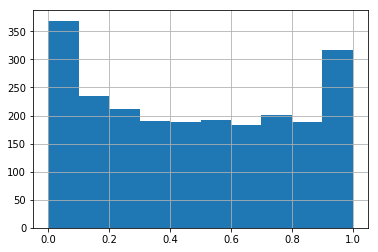

In [26]:
class_rd_submission.pred.hist()